In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.feynnet

In [3]:
use_signal = [ i for i, m in enumerate(module.full_signal_list) if m in module.signal_list ]

In [4]:
signal = ObjIter([Tree(f, report=False, altfile='test_{base}') for f in tqdm(module.full_signal_list)])
bkg = ObjIter([Tree(module.Run2_UL18.QCD_B_List, altfile='test_{base}')])

100%|██████████| 16/16 [00:09<00:00,  1.69it/s]


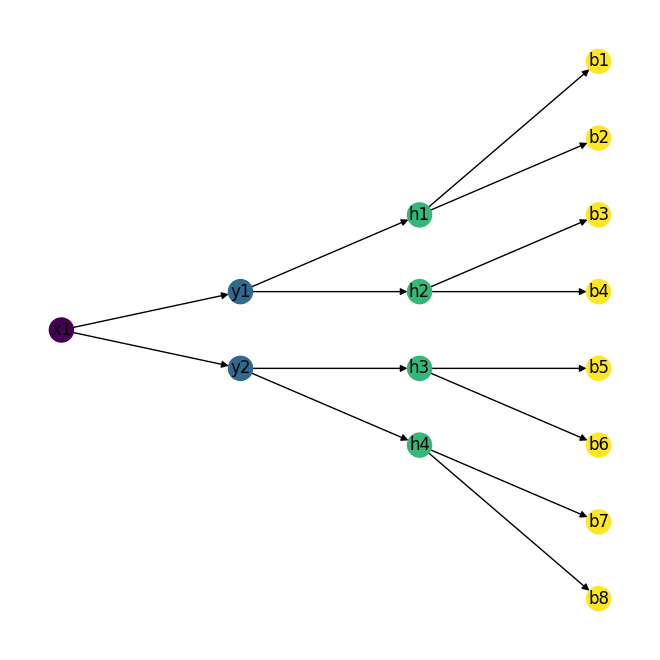

In [5]:
from utils.FeynNet.Feynman import Feynman

x_yy_4h_8b = Feynman('x').decays(
    Feynman('y').decays(
        Feynman('h').decays('b','b'),
        Feynman('h').decays('b','b')
    ),
    Feynman('y').decays(
        Feynman('h').decays('b','b'),
        Feynman('h').decays('b','b')
    )
).build_diagram()
x_yy_4h_8b.draw_diagram()

In [6]:
internalstates = x_yy_4h_8b.get_internalstate_types()

jet_perms = x_yy_4h_8b.get_finalstate_permutations(b=8)['b']
h_b_perms = internalstates['h'][0].get_product_permutations(b=8)['b']
y_h_perms = internalstates['y'][0].get_product_permutations(b=8)['h']
x_y_perms = internalstates['x'][0].get_product_permutations(b=8)['y']

In [7]:
def get_reco(jet_p4, perm):
    p4 = jet_p4[perm]

    h_p4 = p4[:,::2] + p4[:,1::2]
    y_p4 = h_p4[:,::2] + h_p4[:,1::2]
    x_p4 = y_p4[:,0] + y_p4[:,1]

    y_rank = ak_rank( y_p4.pt, axis=1 )
    x_yy_order = ak.argsort(y_rank, ascending=True)

    y_h_rank = ak.unflatten(
            np.repeat(y_rank, 2),
            ak.count(h_p4.pt,axis=1),
        )
    h_rank = ak_rank( h_p4.pt, axis=1 )
    x_yy_4h_order = ak.argsort( 10*y_h_rank + h_rank, ascending=True )

    y_h_j_rank = ak.unflatten(
            np.repeat(y_h_rank, 2),
            ak.count(p4.pt,axis=1),
        )
    j_rank = ak_rank(p4.pt, axis=1)
    x_yy_4h_8b_order = ak.argsort( 100*y_h_j_rank + j_rank, ascending=True)

    y_p4_ordered = y_p4[x_yy_order]
    h_p4_ordered = h_p4[x_yy_4h_order]
    j_p4_ordered = p4[x_yy_4h_8b_order]
    

    return x_p4, y_p4_ordered, h_p4_ordered, j_p4_ordered

In [8]:
def get_reco_perm(jet_p4):
    b_perms = jet_p4[:,h_b_perms]
    b_hid = b_perms.signalId//2

    h_p4 = b_perms[:,:,0] + b_perms[:,:,1]
    h_id = ak.where( b_hid[:,:,0]==b_hid[:,:,1], b_hid[:,:,0], -1)

    h_perms = h_p4[:,y_h_perms]
    h_yid = h_id[:,y_h_perms]//2

    y_p4 = h_perms[:,:,0] + h_perms[:,:,1]
    y_id = ak.where( h_yid[:,:,0]==h_yid[:,:,1], h_yid[:,:,0], -1)

    y_perms = y_p4[:,x_y_perms]
    y_xid = y_id[:,x_y_perms]//2

    x_p4 = y_perms[:,:,0] + y_perms[:,:,1]
    x_id = ak.where( y_xid[:,:,0] == y_xid[:,:,1], y_xid[:,:,0], -1)

    x_4h_m = ak.flatten(h_perms.m[:,x_y_perms], axis=3)
    x_2y_m = y_perms.m
    x_m = x_p4.m

    return x_2y_m, x_4h_m, x_id

In [9]:
eightb_signal = signal.apply(EventFilter('all_eightb', filter=lambda t : t.nfound_select==8))

In [10]:
signal_fit = eightb_signal.apply(lambda t : t.subset(nentries=1500))

In [11]:
fit_jet_p4 = signal_fit.apply(lambda t : build_p4(t, 'jet', use_regressed=True, extra=['signalId'])).cat

In [12]:
fit_dataset = get_reco_perm(fit_jet_p4)

In [13]:
class mass_chi2:
    def __init__(self, a=1, b=1, k=2):
        self.a = a
        self.b = b

        self.k = k

    def func(self, a, b, x_2y_m, x_4h_m):
        m_chi2 = a * ( (x_2y_m[:,:,0] - x_2y_m[:,:,1])/(x_2y_m[:,:,0] + x_2y_m[:,:,1]) )**2 + b * ak.sum( ( (x_4h_m - 125)/25 )**2, axis=2)
        return m_chi2

    def fit_func(self, x0, x_2y_m, x_4h_m, x_id):
        m_chi2 = self.func(*x0, x_2y_m, x_4h_m)
        reco_order = x_id[ak.argsort(m_chi2, axis=1)]

        reco_hitk = ak.mean(ak.any(reco_order[:,:self.k] == 0, axis=1))
        return 1 - reco_hitk
        
        # reco_eff = x_id[ak.argmin(m_chi2, axis=1, keepdims=True)][:,0]
        # reco_eff = ak.mean( x_id == 0 )
        # return 1 - reco_eff

    def __call__(self, x_2y_m, x_4h_m):
        return self.func(self.a, self.b, x_2y_m, x_4h_m)

f_chi2 = mass_chi2(k=1)

In [14]:
from scipy.optimize import fmin 

f_chi2 = mass_chi2(*fmin(f_chi2.fit_func, [1,1], fit_dataset))

Optimization terminated successfully.
         Current function value: 0.734917
         Iterations: 10
         Function evaluations: 39


In [15]:
def get_best_perm(jet_p4):
    x_2y_m, x_4h_m, x_id = get_reco_perm(jet_p4)

    m_chi2 = f_chi2(x_2y_m, x_4h_m)

    reco_rank = ak.min(m_chi2, axis=1)
    best_perms = jet_perms[ak.argmin( m_chi2, axis=1)]
    
    return ak.from_regular(best_perms), reco_rank

In [16]:
def mass_fit_reco(t):
    jet_p4 = build_p4(t, 'jet', use_regressed=True, extra=['signalId'])

    best_perm, reco_rank = get_best_perm(jet_p4)
    x_p4, y_p4, h_p4, j_p4 = get_reco(jet_p4, best_perm)

    t.extend(
        reco_rank=reco_rank,
        X_m=x_p4.m,
        **{
            f"{Y}_m":y_p4.m[:,i]
            for i, Y in enumerate(eightb.ylist)
        },
        **{
            f"{H}_m":h_p4.m[:,i]
            for i, H in enumerate(eightb.higgslist)
        },
        **{
            f"{J}_signalId":j_p4.signalId[:,i]
            for i, J in enumerate(eightb.quarklist)
        }
    )

In [17]:
(signal+bkg).apply(mass_fit_reco, report=True)

100%|██████████| 9/9 [06:16<00:00, 41.84s/it]


[None, None, None, None, None, None, None, None, None]

In [18]:
def fully_reconstructed(t):
            h_b_ids = [ t[f'{quark}_signalId'] // 2 for quark in eightb.quarklist ]
            y_h_ids = [ ak.where(h_b1_id == h_b2_id, h_b1_id, -1) // 2 for h_b1_id, h_b2_id in zip(h_b_ids[::2], h_b_ids[1::2]) ]
            y1_id, y2_id = [ ak.where(y_h1_id == y_h2_id, y_h1_id, -1) // 2 for y_h1_id, y_h2_id in zip(y_h_ids[::2], y_h_ids[1::2]) ]
            reco_id = ak.where(y1_id == y2_id, y1_id, -1)
            t.extend(
                reco_id = reco_id
            )
(signal).apply(fully_reconstructed)

[None, None, None, None, None, None, None, None]

In [19]:
eightb_signal = signal.apply(EventFilter('all_eightb', filter=lambda t : t.nfound_select==8))
partial_signal = signal.apply(EventFilter('partial_eightb', filter=lambda t : t.nfound_select< 8))

100%|██████████| 1/1 [00:05<00:00,  5.39s/it]


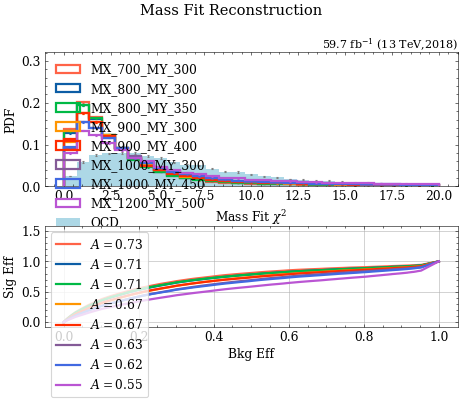

In [20]:
study.quick(
    signal+bkg,
    legend=True,
    h_label_stat=None,
    varlist=['reco_rank'],
    binlist=[(0,20,30)],
    xlabels=['Mass Fit $\chi^2$'],
    suptitle='Mass Fit Reconstruction',
    efficiency=True,

    **study.auroc,
)

100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

x_mean=3.500
x_std=2.291
x_min=0.000
x_max=7.000
y_mean=0.024
y_std=0.011
y_min=0.010
y_max=0.048
x_sum=28.000
y_sum=0.195
area=0.167
ndf=8.000


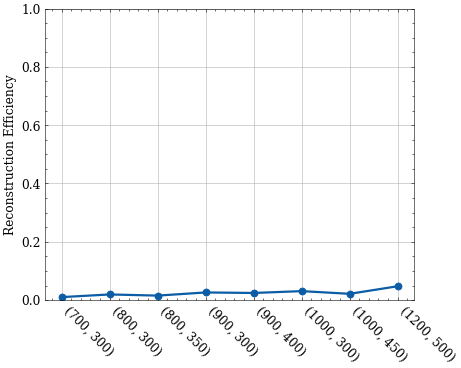

In [21]:
study.statsplot(
    eightb_signal,
    label=signal.mass.list,
    varlist=['reco_id'],
    xlabels=['Reconstruction Efficiency'],
    efficiency=True,

    stat=lambda h:h.histo[-1],
    stat_err=lambda h:h.error[-1],
    g_grid=True,
    g_exe=lambda graph, **kwargs: print( f'{graph.stats:0.3f}'),
    g_ylim=(0,1),
)

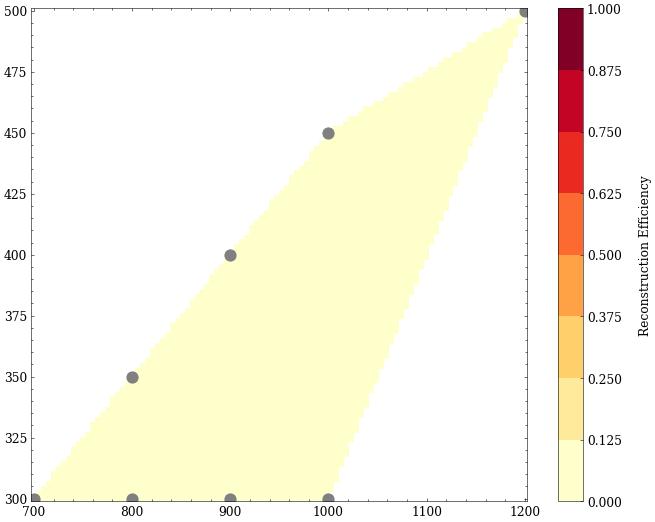

In [21]:
study.mxmy_phase(
    eightb_signal,
    label=signal.mass.list,
    zlabel='Reconstruction Efficiency',
    efficiency=True,

    f_var=lambda t: ak.mean(t.reco_id==0),
    zlim=np.linspace(0,1,9),

)

In [34]:
varinfo.X_m =   dict(bins=(400,2000,30), xlabel='$M_{X}$ (GeV)')
varinfo.Y1_m =  dict(bins=(100,1000,30), xlabel='Leading Y Boson Mass (GeV)')
varinfo.Y2_m =  dict(bins=(100,1000,30), xlabel='Subleading Y Boson Mass (GeV)')
varinfo.H1Y1_m =   dict(bins=(0,300,30), xlabel='Leading Y\'s Leading Higgs Boson Mass (GeV)')
varinfo.H2Y1_m =   dict(bins=(0,300,30), xlabel='Leading Y\'s Subleading Higgs Boson Mass (GeV)')
varinfo.H1Y2_m =   dict(bins=(0,300,30), xlabel='Subleading Y\'s Leading Higgs Boson Mass (GeV)')
varinfo.H2Y2_m =   dict(bins=(0,300,30), xlabel='Subleading Y\'s Subleading Higgs Boson Mass (GeV)')


100%|██████████| 8/8 [00:01<00:00,  6.64it/s]


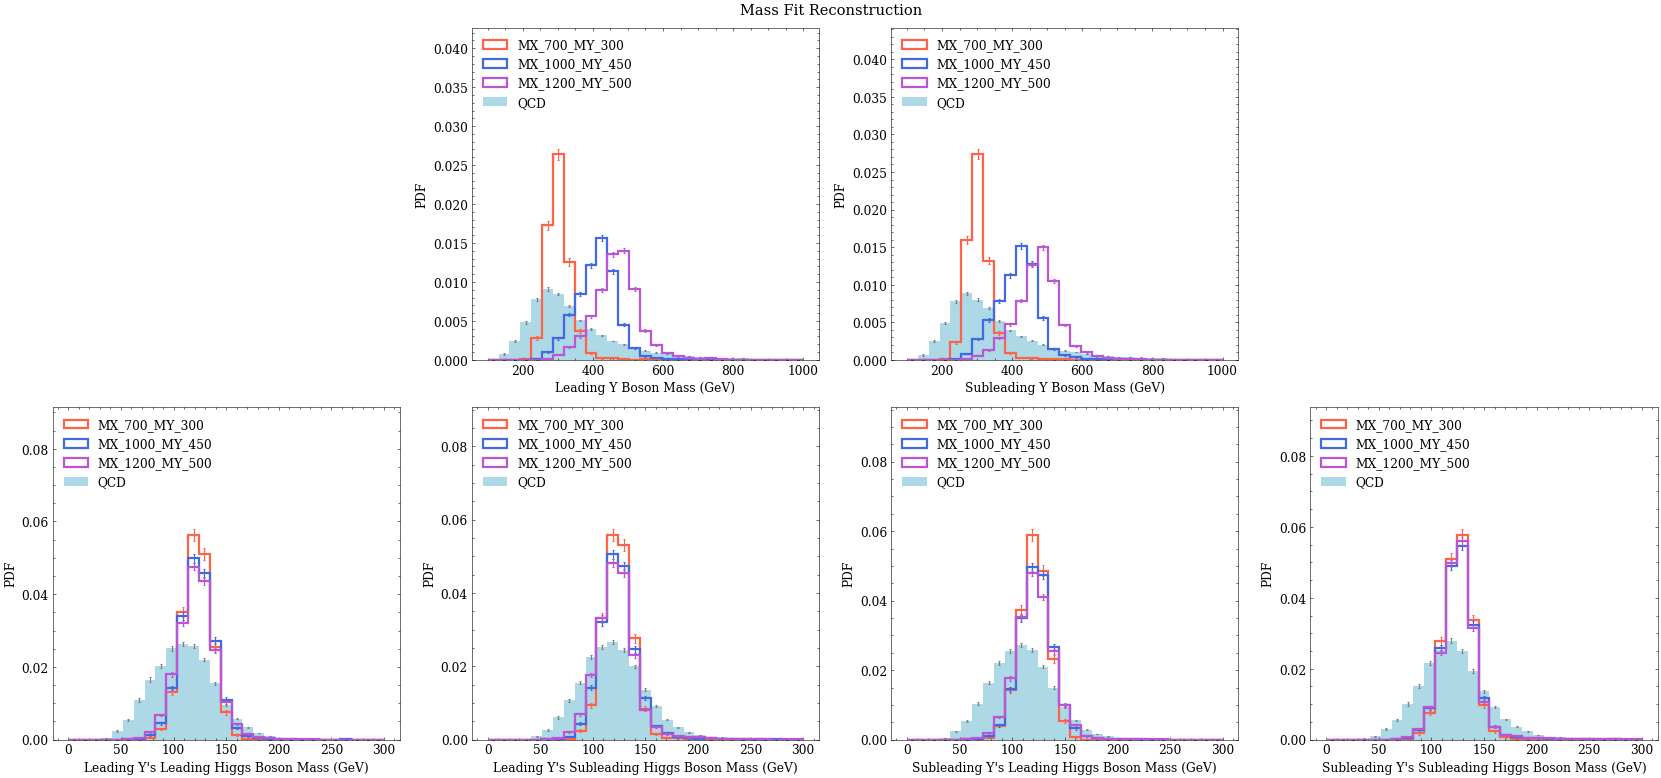

In [35]:
study.quick(
    eightb_signal[use_signal]+bkg,
    legend=True,
    h_label_stat=None,
    varlist=[None,'Y1_m','Y2_m',None,'H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
    suptitle='Mass Fit Reconstruction',
    lumi=None,
    density=True,
)